In [1]:
import sys, os
os.chdir(sys.path[0]+'./search')

from pacman import runGames, loadAgent
from pacman import Directions
import pacmanAgents
from util import Queue
import textDisplay
import game
import layout
import random
import graphicsDisplay

import numpy as np

In [15]:
class SmartAgentNew(game.Agent):    
    def __init__(self, pesos):
        self.pesos = pesos
        
    def getAction(self, state):
        legal = state.getLegalPacmanActions()
        if Directions.STOP in legal: legal.remove(Directions.STOP)
    
        currentState = state
        
        successors = [(state.generateSuccessor(0, action), action) for action in legal]
        scored = [(self.scoreEvaluation(state, currentState), action) for state, action in successors]
        bestScore = max(scored)[0]
        bestActions = [pair[1] for pair in scored if pair[0] == bestScore]
        
        return random.choice(bestActions)
        
    def getNeighbors(self, pos, walls, visited):
        c, l = pos
        neighbors = []
        
        for i in range(-1,2,1):
            for j in range(-1,2,1):
                if(abs(i) != abs(j) and c+i < walls.width and c+i >= 0 and l+j < walls.height and l+j >= 0):
                    if(walls[c+i][l+j] == False and visited[c+i][l+j] == 0):
                        neighbors.append((c+i,l+j))             
        return neighbors
        
    def bfsDistance(self, state, posIni, endPos = None, food = False):
        queue = Queue()
        
        walls = state.getWalls()
        if(food):
            foods = state.getFood()
            
        visited = np.zeros((walls.width,walls.height))
        visited[posIni[0]][posIni[1]] = 1
                
        queue.push((posIni, 1))
        while(not queue.isEmpty()):
            current = queue.pop()
            pos = current[0]
            stepsUntilNow = current[1]
            
            if(food == True):
                if(foods[pos[0]][pos[1]] == True):
                    return stepsUntilNow
            else:
                if(pos[0] == endPos[0] and pos[1] == endPos[1]):
                    return stepsUntilNow
    
            visited[pos[0]][pos[1]] = 1
            possibles = self.getNeighbors(pos,walls, visited)
            for possibleMove in possibles:
                queue.push((possibleMove, stepsUntilNow+1))
        return -1
    
    def ghosts(self, state):
        ghostsPos = state.getGhostPositions()
        n_ghosts = len(ghostsPos)
        
        scared_timer = []
        positionsNonScared = []
        positionsScared = []
        
        for i in range(n_ghosts):
            scared_timer.append(state.getGhostStates()[i].scaredTimer)
            
        for i in range(n_ghosts):
            if(scared_timer[i] == 0):
                positionsNonScared.append(np.ceil(ghostsPos[i]))
            else:
                positionsScared.append(np.ceil(ghostsPos[i]))
            
        return positionsScared, positionsNonScared
    
    def nearstElement(self, state, posElement, pacmanPos):
        minDist = float('inf')
        for pos in posElement:
            dist = self.bfsDistance(state, pacmanPos, pos)
            if(dist < minDist):
                minDist = dist
        return minDist
            
    def countScaredGhosts(self, state):
        total=0
        for ghost in state.getGhostStates():
            if(ghost.scaredTimer !=0):
                total+=1
        return total
    
    def scoreEvaluation(self, state, currentState):
        
        p1 = self.pesos[0]   # peso relacionado à distancia do fantasma malvado 
        p2 = self.pesos[1]   # peso relacionado à distancia do fantasma assustado mais próximo
        p3 = self.pesos[2]   # peso relacionado a comer um fantasma assustado
        p4 = self.pesos[3]   # peso relacionado à distancia da comida mais próxima
        p5 = self.pesos[4]   # peso relacionado a comer uma comida
        p6 = self.pesos[5]   # peso relacionado à distancia da capsula mais próxima
        p7 = self.pesos[6]   # peso relacionado a comer uma capsula
        
        score = state.getScore()
        scaredGhosts, badGhosts = self.ghosts(state)
        pacman = state.getPacmanPosition()
        capsules = state.getCapsules()
        
        avaliacao = score
        ################## Bad Ghost in next position  #################
        if(len(badGhosts) > 0):
            distBadGhost = self.nearstElement(state, badGhosts, pacman)
            if(distBadGhost <= p1):
                return float('-inf')
            
        ################## Nearst Scared Ghosts ####################
        if(len(scaredGhosts) > 0):
            distScaredGhosts = self.nearstElement(state, scaredGhosts, pacman)
            avaliacao += p2*(1/distScaredGhosts)
            
        ############### Eat scared ghost bonus #################
        numScaredCurrent = self.countScaredGhosts(currentState)
        numScared = self.countScaredGhosts(state)
        scaredDiff = numScaredCurrent - numScared
        if(scaredDiff > 0):
            avaliacao += p3 * scaredDiff
            
        ################ Nearst food ###################
        nearestFood = self.bfsDistance(state, pacman, food = True)
        avaliacao += p4*(1/nearestFood)
        
        ################ Eat food bonus ##################
        numfood= state.getFood()
        numFoodCurrent = currentState.getFood()
        foodDiff = numFoodCurrent.count(True) - numfood.count(True)
        avaliacao += p5*foodDiff
        
        ################# Nearst capsule ################
        if(len(capsules) > 0):
            distCapsule = self.nearstElement(state, capsules, pacman)
            avaliacao += p6*(1/distCapsule)
        
        ################# Eat capsule bonus ##############
        numcapsules = len(state.getCapsules())
        numCapsulesCurrentState = len(currentState.getCapsules())
        avaliacao += p7*(numCapsulesCurrentState - numcapsules)
        
        return avaliacao

In [3]:
def fitfunction(pesos):
    props={}
    pacman = SmartAgentNew(pesos)
    ghostType = loadAgent('RandomGhost', True)
    textDisplay.SLEEP_TIME = 0
    props['layout'] = layout.getLayout( 'smallClassic' )
    props['pacman'] = pacman
    props['ghosts'] = [ghostType( i+1 ) for i in range( 2 )]
    props['display'] = textDisplay.NullGraphics()
    #props['display'] = graphicsDisplay.PacmanGraphics(1, frameTime = 0)
    props['numGames'] = 1
    props['record'] = False
    props['catchExceptions'] = True
    props['timeout'] = 1
    
    res = runGames(**props)
    scores = [game.state.getScore() for game in res]
    avgScore = sum(scores) / float(len(scores))
     
    return avgScore

In [7]:
fitfunction([2,10,2,3,1,1,2,1])

1735.0

In [14]:
import geneticalgsmod as ge

model = ge.RealGA(fitness_func = fitfunction, optim='max', selection="rank", mut_prob=0.12, mut_type=1,
                  cross_prob=0.9, cross_type=1, elitism=True, tournament_size=None)

In [5]:
population_size = 60
dimensao = 7  #numero de argumentos da funcao        
interval = (0,100)
model.init_random_population(population_size, dimensao, interval)

In [6]:
max_generation = 35
fitness_progress, best_individual, worst_individual = model.run(max_generation)

Geração 1 terminada
Geração 2 terminada
Geração 3 terminada
Geração 4 terminada
Geração 5 terminada
Geração 6 terminada
Geração 7 terminada
Geração 8 terminada
Geração 9 terminada
Geração 10 terminada
Geração 11 terminada
Geração 12 terminada
Geração 13 terminada
Geração 14 terminada
Geração 15 terminada
Geração 16 terminada
Geração 17 terminada
Geração 18 terminada
Geração 19 terminada
Geração 20 terminada
Geração 21 terminada
Geração 22 terminada
Geração 23 terminada
Geração 24 terminada
Geração 25 terminada
Geração 26 terminada
Geração 27 terminada
Geração 28 terminada
Geração 29 terminada
Geração 30 terminada
Geração 31 terminada
Geração 32 terminada
Geração 33 terminada
Geração 34 terminada
Geração 35 terminada


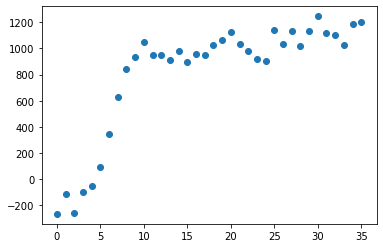

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

x1 = list(range(len(fitness_progress)))

plt.plot(x1, fitness_progress, 'o')

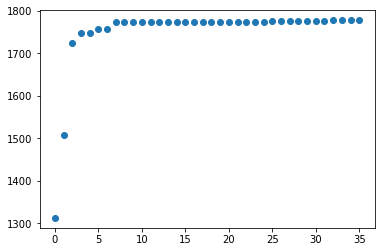

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

x1 = list(range(len(best_individual)))

plt.plot(x1, best_individual, 'o')

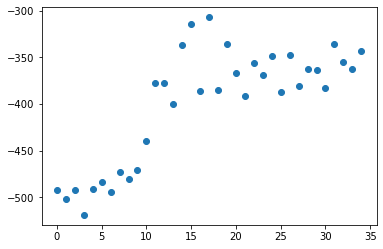

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

x1 = list(range(len(worst_individual)))

plt.plot(x1, worst_individual, 'o')

In [10]:
new_pesos = model.best_solution[0].tolist()
new_pesos

[4.0194955275284,
 84.00098228908621,
 2.4812017152692154,
 0.42187505591324015,
 4.485319137689665,
 70.55600553483248,
 29.361416451589548]

In [11]:
maior = 0
for best in model.population:
    if(best.fitness_val > maior):
        maior = best.fitness_val
        melhor_peso = best.chromosome
melhor_peso, maior

(array([ 4.01949553, 84.00098229,  2.48120172,  0.42187506,  4.48531914,
        70.55600553, 29.36141645]),
 1778.0)

In [13]:
props={}
pacman = SmartAgentNew(new_pesos)
ghostType = loadAgent('RandomGhost', True)
textDisplay.SLEEP_TIME = 0
props['layout'] = layout.getLayout( 'smallClassic' )
props['pacman'] = pacman
props['ghosts'] = [ghostType( i+1 ) for i in range( 2 )]
#props['ghosts'] = []
props['display'] = graphicsDisplay.PacmanGraphics(1, frameTime = 0)
#props['display'] = textDisplay.NullGraphics()
props['numGames'] = 10
props['record'] = False
props['catchExceptions'] = True
props['timeout'] = 2
    
games = runGames(**props)
scores = [game.state.getScore() for game in games]
avg = sum(scores) / float(len(scores))
int(avg)

1404